In [1]:
import os
import sys
import shutil
sys.path.append("../python/")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image
import cv2
from matplotlib import cm

from helpers import *
from visualize_network import grad_cam

{336: {'PrPo_Im': array([[array([[[0.40392157, 0.50980392, 0.32156863],
                [0.4745098 , 0.57647059, 0.33333333],
                [0.56078431, 0.6627451 , 0.35686275],
                ...,
                [0.20784314, 0.27843137, 0.18431373],
                [0.13333333, 0.19607843, 0.14509804],
                [0.1254902 , 0.18823529, 0.1372549 ]],

               [[0.39215686, 0.50980392, 0.29411765],
                [0.52156863, 0.64313725, 0.32941176],
                [0.41568627, 0.53333333, 0.2745098 ],
                ...,
                [0.17647059, 0.23921569, 0.17254902],
                [0.12941176, 0.19607843, 0.14901961],
                [0.11372549, 0.17647059, 0.1372549 ]],

               [[0.25098039, 0.36470588, 0.29411765],
                [0.31372549, 0.41960784, 0.30196078],
                [0.35686275, 0.47058824, 0.31764706],
                ...,
                [0.11372549, 0.16862745, 0.12941176],
                [0.11372549, 0.17647059, 0.12941176

In [2]:
RESOLUTION_LIST = [336]
LOC = 4
SCENARIO_LIST = ["PrPo_Im"]
AUGMENTATION = 'fliplr'
CD_MODEL_PATH = '../../results/cd/models/conf-det-test-inception_v3--w-336-px-h-336-px/model'
VIS_INDEX_PATH = '../../results/vis/index/tp_index.csv'

In [3]:
source_directory = '../../data/vis/input/tiles/'
destination_directory = '../../data/vis/input/test/non_processed'
dest_processed = '../../data/vis/input/test//processed/'

In [4]:
cd_model = models.load_model(CD_MODEL_PATH)
vis_index = pd.read_csv(VIS_INDEX_PATH)
# Edit the preprocessed_index column to exclude 'test-'
vis_index['preprocessed_index'] = vis_index['preprocessed_index'].str.replace('test-', '')

### Risk Prediction Images & Labels

In [5]:
IMAGE_SETS_SQUARE_TRAIN = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST, augmentation=AUGMENTATION, type='train', rectangular = False, testing=False)
IMAGE_SETS_SQUARE_TEST = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST, augmentation=AUGMENTATION, type='test', rectangular = False, testing=False)

{336: {'PrPo_Im': array([[array([[[0.40392157, 0.50980392, 0.32156863],
                [0.4745098 , 0.57647059, 0.33333333],
                [0.56078431, 0.6627451 , 0.35686275],
                ...,
                [0.20784314, 0.27843137, 0.18431373],
                [0.13333333, 0.19607843, 0.14509804],
                [0.1254902 , 0.18823529, 0.1372549 ]],

               [[0.39215686, 0.50980392, 0.29411765],
                [0.52156863, 0.64313725, 0.32941176],
                [0.41568627, 0.53333333, 0.2745098 ],
                ...,
                [0.17647059, 0.23921569, 0.17254902],
                [0.12941176, 0.19607843, 0.14901961],
                [0.11372549, 0.17647059, 0.1372549 ]],

               [[0.25098039, 0.36470588, 0.29411765],
                [0.31372549, 0.41960784, 0.30196078],
                [0.35686275, 0.47058824, 0.31764706],
                ...,
                [0.11372549, 0.16862745, 0.12941176],
                [0.11372549, 0.17647059, 0.12941176

In [6]:
class_labels = getClassLabels(SCENARIO_LIST[0])
training_images, training_labels = getImageAndLabelArrays(IMAGE_SETS_SQUARE_TRAIN[RESOLUTION_LIST[0]][SCENARIO_LIST[0]])
test_images, test_labels = getImageAndLabelArrays(IMAGE_SETS_SQUARE_TEST[RESOLUTION_LIST[0]][SCENARIO_LIST[0]])

In [7]:
print(vis_index.iloc[LOC])
labeled_image = vis_index.iloc[LOC].values[0].rstrip('.jpg')
preprocessed_index = int(vis_index.iloc[LOC].values[1])

labeled_image         possible-121.jpg
preprocessed_index                 111
Name: 4, dtype: object


In [8]:
def returnGCAMheatmap(index):
    gcam = grad_cam([index])
    heatmap = np.uint8(cm.jet(gcam[0])[..., :3] * 255)
    return (gcam,heatmap)

In [9]:
def renderGCAMheatmap(gcam_heatmap):
    plt.imshow(np.squeeze(gcam_heatmap[0][1]), cmap='gist_gray') # remove axes of length one from gradcam_images
    plt.imshow(gcam_heatmap[1], cmap='gist_gray', alpha=0.5) # overlay
    plt.axis('off')
    plt.tight_layout()

In [10]:
gradcam_heatmap = returnGCAMheatmap(preprocessed_index)

Observed image class:  Probable/Possible
Class labels:  ['Improbable', 'Probable/Possible']
Loss output:  tf.Tensor([[-1.0305506   0.37561554]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=0.37561554>]
Probability of prediction:  ['0.8']
Predicted class:  ['Probable/Possible']
[array([0.19683945, 0.8031605 ], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)


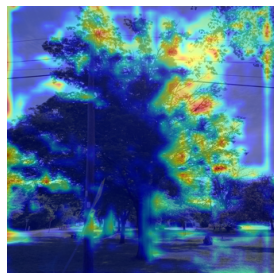

In [11]:
renderGCAMheatmap(gradcam_heatmap)

In [12]:
# List all files in the source directory
files = os.listdir(source_directory)

shutil.rmtree(destination_directory, ignore_errors=True)
os.makedirs(destination_directory)

# Iterate through the files in the source directory
for file in files:
    if file.startswith(labeled_image):
        # If the file starts with 'possible_121', construct the source and destination paths
        source_file = os.path.join(source_directory, file)
        destination_file = os.path.join(destination_directory, file)
        
        # Copy the file from the source directory to the destination directory
        shutil.copyfile(source_file, destination_file)

In [17]:
image_list = os.listdir(destination_directory)
data_filename = 'cd_draw_predictions.npy'
processed_data_filepath = os.path.join(dest_processed, data_filename)

shutil.rmtree(dest_processed, ignore_errors=True)
os.makedirs(dest_processed)

data = []
for image in image_list:
    path = os.path.join(destination_directory, image)
    image = Image.open(path) # read in image
    image = image.resize((336, 336), Image.NEAREST) 
    scaled_image_array = np.array(image)/255.
    data.append([scaled_image_array])

np.save(processed_data_filepath, data)

In [18]:
images_data = np.load(processed_data_filepath)

In [27]:
# Make predictions on the images using the loaded model
predictions = cd_model.predict(np.squeeze(images_data))

In [28]:
# Interpret the predictions of the two-class classification problem with softmax activation
class_labels = np.argmax(predictions, axis=1)

In [29]:
class_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

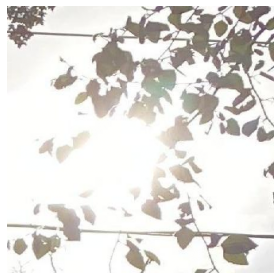

In [43]:
plt.imshow(np.squeeze(images_data[15]))
plt.axis('off')
plt.tight_layout()